# 化工行业碳排放量预测模型

本笔记本使用XGBoost模型对化工企业的碳排放量进行预测。

In [19]:
# 导入所需的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# 确保可以导入工具模块
sys.path.append(os.path.abspath("./"))
from chemical_emission_prediction import *

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

## 1. 数据加载与预处理

In [20]:
# 加载和预处理数据
df = load_and_preprocess_data("./datasets/化工行业.csv")
df.head()

,企业,年份,燃料活动水平,燃烧排放因子,原材料活动水平,生产过程排放因子,净购入电量,电力排放因子,燃料燃烧排放量,生产过程排放量,净购电排放量,碳排放量,燃料数值,燃料类型,原材料数值,原材料类型,电力排放区域,电力排放因子值
0,中国石化-燕山石化,2021,120 (煤炭),2.85,85 (乙烯),0.45,15.2,0.85 (华北),342.0,38.3,12.9,393.2,120.0,煤炭,85.0,乙烯,华北,0.85
1,中国石油-大庆石化,2022,95 (天然气),2.18,72 (丙烯),0.38,18.5,0.72 (东北),207.1,27.4,13.3,247.8,95.0,天然气,72.0,丙烯,东北,0.72
2,万华化学-烟台MDI,2023,68 (重油),3.12,50 (苯胺),0.52,22.0,0.78 (华东),212.2,26.0,17.2,255.4,68.0,重油,50.0,苯胺,华东,0.78
3,恒力石化-大连炼化,2021,150 (石油焦),3.45,105 (PX),0.60,28.5,0.65 (南方),517.5,63.0,18.5,599.0,150.0,石油焦,105.0,PX,南方,0.65
4,荣盛石化-舟山PX,2022,135 (煤炭),2.90,92 (对二甲苯),0.55,25.7,0.72 (华东),391.5,50.6,18.5,460.6,135.0,煤炭,92.0,对二甲苯,华东,0.72


## 2. 使用utils.py中的化工行业排放计算函数计算排放量

In [ ]:
# 计算排放量
df = calculate_total_emission(df)
df[
    [
        "燃料燃烧排放量",
        "计算燃料燃烧排放量",
        "生产过程排放量",
        "计算生产过程排放量",
        "净购电排放量",
        "计算净购电排放量",
        "碳排放量",
        "计算总排放量",
    ]
].head()

,燃料燃烧排放量,计算燃料燃烧排放量,生产过程排放量,计算生产过程排放量,净购电排放量,计算净购电排放量,碳排放量,计算总排放量
0,342.0,342.00,38.3,38.25,12.9,12.920,393.2,393.170
1,207.1,207.10,27.4,27.36,13.3,13.320,247.8,247.780
2,212.2,212.16,26.0,26.00,17.2,17.160,255.4,255.320
3,517.5,517.50,63.0,63.00,18.5,18.525,599.0,599.025
4,391.5,391.50,50.6,50.60,18.5,18.504,460.6,460.604


## 3. 数据可视化分析

c:\Users\kyoci\anaconda3\envs\citi\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


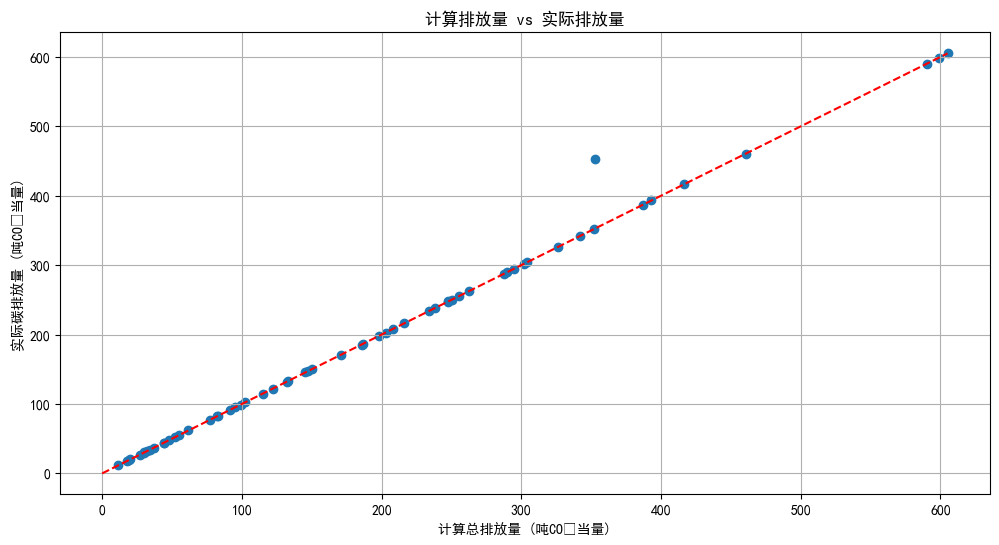

计算排放量和实际排放量的相关系数: 0.9966


c:\Users\kyoci\anaconda3\envs\citi\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


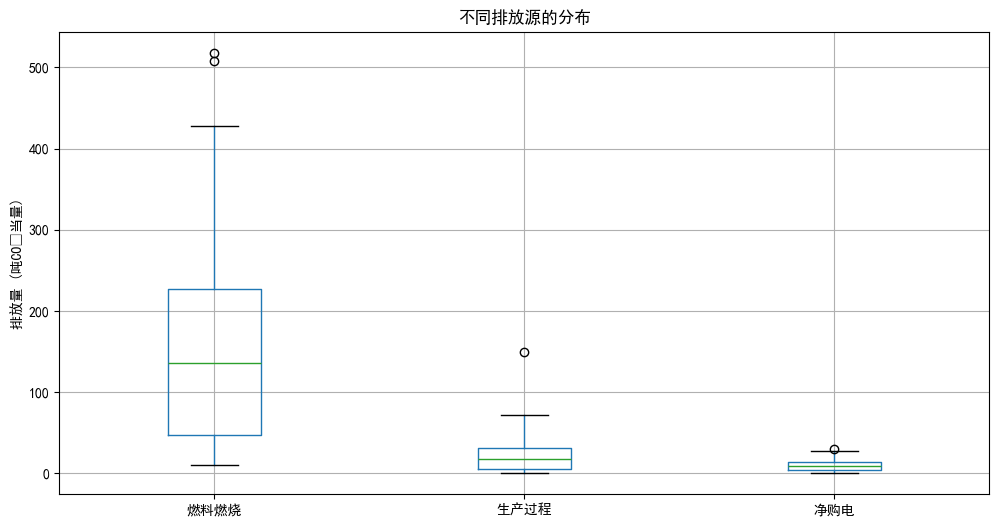

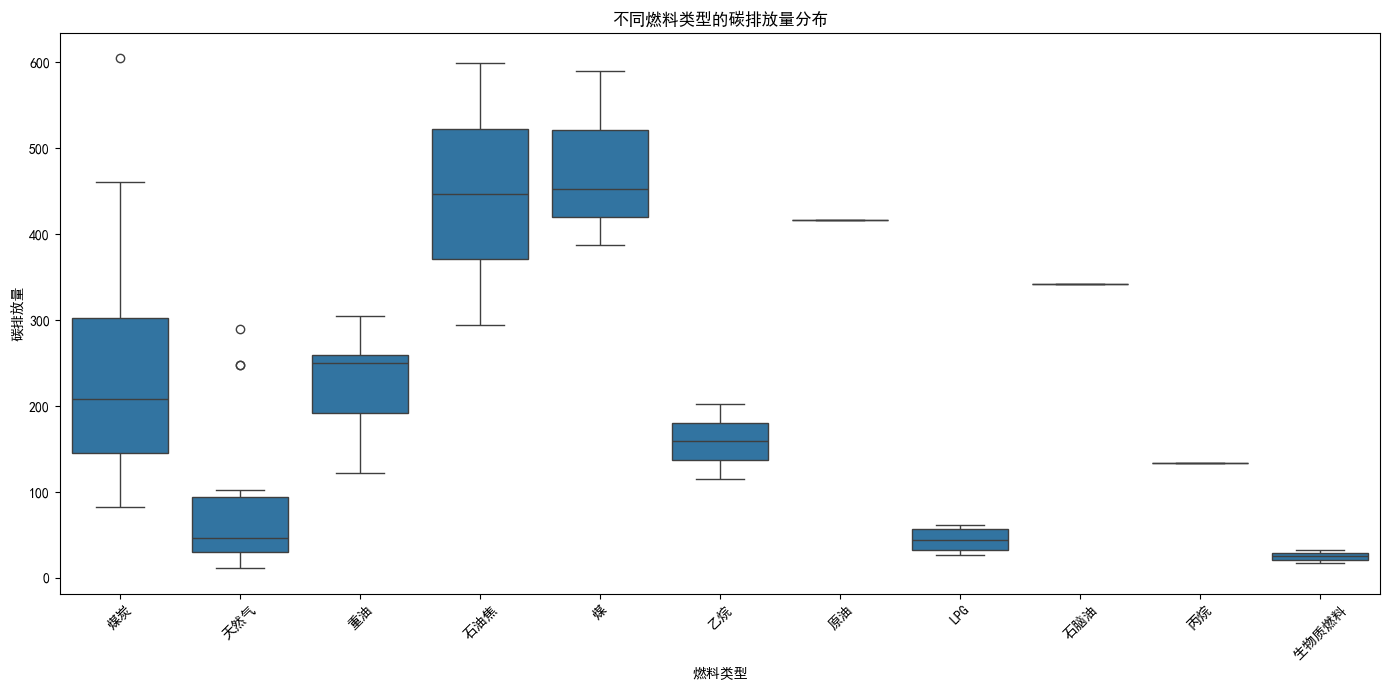

In [ ]:
# 绘制计算排放量和实际排放量的对比
plt.figure(figsize=(12, 6))
plt.scatter(df["计算总排放量"], df["碳排放量"])
plt.plot([0, df["碳排放量"].max()], [0, df["碳排放量"].max()], "r--")
plt.xlabel("计算总排放量 (吨CO₂当量)")
plt.ylabel("实际碳排放量 (吨CO₂当量)")
plt.title("计算排放量 vs 实际排放量")
plt.grid(True)
plt.show()

# 计算相关性
corr = df["计算总排放量"].corr(df["碳排放量"])
print(f"计算排放量和实际排放量的相关系数: {corr:.4f}")

# 绘制各组成部分的排放量
emission_components = df[
    ["计算燃料燃烧排放量", "计算生产过程排放量", "计算净购电排放量"]
].copy()
emission_components.columns = ["燃料燃烧", "生产过程", "净购电"]

plt.figure(figsize=(12, 6))
emission_components.boxplot()
plt.title("不同排放源的分布")
plt.ylabel("排放量 (吨CO₂当量)")
plt.grid(True)
plt.show()

# 按燃料类型分组比较排放量
plt.figure(figsize=(14, 7))
sns.boxplot(x="燃料类型", y="碳排放量", data=df)
plt.title("不同燃料类型的碳排放量分布")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. 模型训练与评估

模型评估结果:
RMSE: 10.20
R²: 1.00

特征重要性排名:
     feature  importance
6     计算总排放量    0.334537
2      原材料数值    0.333527
0       燃料数值    0.267498
62   原料_聚氯乙烯    0.021115
4      净购入电量    0.013194
3   生产过程排放因子    0.007011
13     燃料_煤炭    0.004589
79     区域_华北    0.003626
40   原料_对二甲苯    0.003446
1     燃烧排放因子    0.002170


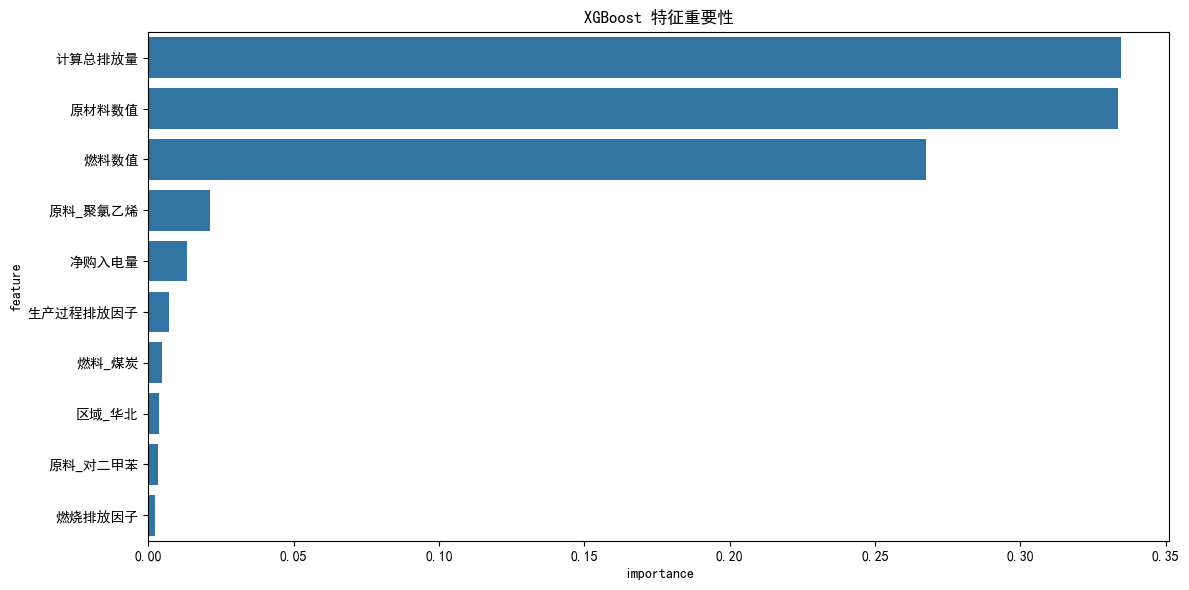

In [ ]:
# 准备训练数据
(
    X_train,
    X_test,
    y_train,
    y_test,
    scaler,
    numeric_cols,
    fuel_types,
    material_types,
    regions,
) = prepare_training_data(df)

# 训练XGBoost模型
model, feature_importance, rmse, r2 = train_xgboost_model(
    X_train, y_train, X_test, y_test
)

## 5. 预测GUI界面

In [ ]:
# 创建GUI界面
gui = create_prediction_gui(
    model, scaler, numeric_cols, fuel_types, material_types, regions, df
)
display(gui)

## 6. 保存模型

In [ ]:
# 保存模型
import joblib

# 保存XGBoost模型
joblib.dump(model, "./chemical_emission_model.pkl")

# 保存标准化器
joblib.dump(scaler, "./chemical_emission_scaler.pkl")

# 保存特征列名
feature_data = {
    "numeric_cols": numeric_cols,
    "fuel_types": list(fuel_types),
    "material_types": list(material_types),
    "regions": list(regions),
}
joblib.dump(feature_data, "./chemical_emission_feature_data.pkl")

print("模型和相关数据已保存")

模型和相关数据已保存
